# Ear Detection
#### In this project we tried to implement the approach discussed in the paper in order to detect ears from side face images.
#### We used two different datasets, training set which is for buiding our model and testing set which we use to test our model.
#### In the code below we have written a couple of functions which refers to every step discussed in paper.


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import shape_index
import os
import math
import sys
import scipy
from skimage import morphology
from scipy import ndimage

In [2]:
#to find distance between two vectors(histograms) 
def divergence(vec1, vec2):
    d = 0
    for i in range(len(vec1)):
        d += ((vec1[i]-vec2[i])**2)/(vec1[i]+vec2[i])
    return np.sqrt(d)

In [3]:
#to remove the components whose region is very small
J=None
def removingSmallBlobs(img):
    img2 = morphology.remove_small_objects(img.astype(int), min_size=50, connectivity=8)
    return img2

In [4]:
# return the histogram of shape index of a given image
def processingModel(img):
    shapeIndex = shape_index(img)
    hist,bins= np.histogram(shapeIndex,bins=50, density = True, range=[-0.9999, 1])
    return hist,bins

In [5]:
# return the histogram of a given image, with desired threshold applied to edge-detector, from a given image
def processing(img, th1, th2):
    image = img
    x1 = cv2.Canny(image,th1,th2)
    kernel = np.ones((3,3), np.uint8)*255
    lap = cv2.dilate(x1, kernel, iterations=1)
    lap = removingSmallBlobs(lap)
    shapeIndex = shape_index(lap)
    for i in range(len(shapeIndex)):
        for j in range(len(shapeIndex[0])):
            if math.isnan(shapeIndex[i][j]) :
                shapeIndex[i][j] = -1
    hist,bins = np.histogram(shapeIndex,bins=50, density = True, range=[-1, 1])
    
    return hist, bins

In [6]:
# build the model, the model is the averaged histogram of shape indexes, for all of the files in the folder.
def modelBuilder():
    totalHist =  []
    for file in list(os.listdir('dataset/')):#[:10]:
        fileAddress = 'dataset/'+ file
        image  =  cv2.imread(fileAddress,0)

        hist, bins = processingModel(image)
        totalHist.append(hist)  
    t = np.asarray(totalHist)
    model = np.average(t, axis=0)

    plt.plot(bins[:50], model)
    plt.show()
    return model

In [7]:
#read image using openCV library
def imageReader(address):
    return cv2.imread(address,0)

In [8]:
# edge detection of a given image. Note the thresholds are dependent on dataset
def edging(image):
    return cv2.Canny(image,100,300)

In [9]:
# dilation: thikening (bolding) edges of binary images.  
def dilation(img):
    kernel = np.ones((3,3), np.uint8)*255
    return cv2.dilate(img, kernel, iterations=1)

In [10]:
# component analysis, labeling each component in the binary image
def com_analisys(img):
    return ndimage.label(img)

In [11]:
# find the mean(x,y) of each component in the binary image
def regionMeaner(labeledBinaryImage, nr_objects):
    meansX = [0]*nr_objects
    meansY = [0]*nr_objects
    numPixels = [0]*nr_objects
    for num in range(nr_objects):
        for i in range(len(labeledBinaryImage)):
            for j in range(len(labeledBinaryImage[0])):
                if labeledBinaryImage[i][j] == (num+1):
                    meansX[num] += i
                    meansY[num] += j
                    numPixels[num] += 1

    for i in range(nr_objects):
        if numPixels[i]< 30:
            meansX[i] = 0
            meansY[i] = 0
                
    mX=[0]*nr_objects
    mY=[0]*nr_objects
    for i in range(len(numPixels)):
        mX[i] = meansX[i]/numPixels[i]
        mY[i] = meansY[i]/numPixels[i]     
    return mX, mY

In [12]:
# Check each region of component with the model, and find the most promising component, w.r.t. its historgram distance to model
def regionChecker(model, labeledBinaryImage,nr_objects, mX,mY):     
    minDist = 10
    #cropping the image around means
    for i in range(nr_objects):
        croppedImg =labeledBinaryImage[int(mX[i])-25: int(mX[i])+25, int(mY[i])-25: int(mY[i])+25]

        try:
            shapeIndex = shape_index(croppedImg)
            hist,bins= np.histogram(shapeIndex,bins=50, density = True, range=[-1, 1])
            print(divergence(model, hist))
            if divergence(model, hist) < minDist:
                finalregXMean = mX[i]
                finalregYMean = mY[i]
                
        except Exception:
            pass

    return finalregXMean, finalregYMean

C:\Users\Ziba\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ziba\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


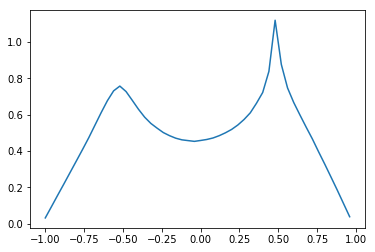

6.441551057571973
6.441551057571973
3.8160990088690254


C:\Users\Ziba\Anaconda3\lib\site-packages\skimage\feature\corner.py:421: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
C:\Users\Ziba\Anaconda3\lib\site-packages\skimage\feature\corner.py:421: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


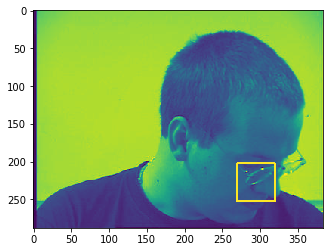

person01102-60-75.jpg
6.441551057571973
6.441551057571973
4.650216417234487
3.739741888893298
3.474617108559614


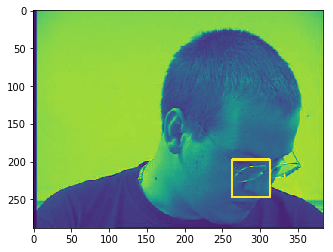

person01103-60-60.jpg
6.441551057571973
2.093548174783616
2.9071708845368964


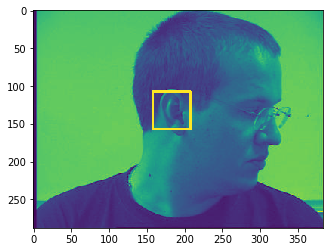

person01114-30-90.jpg
4.941101624003186
3.339073313819824
3.8857072247805564
2.1776928642351683
3.2502138511188052
3.9145385534292325
3.534539090351796
4.033577476229511


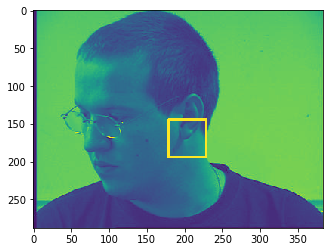

person01124-30+60.jpg
4.612074782253962
3.698932400732966
4.054929194427338
2.6312566756162927
4.4818664354306605
2.9411642891902394
4.604126719198551


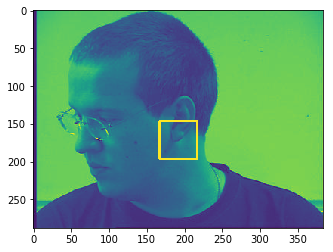

person01125-30+75.jpg
4.103619421088638
4.254843726334463
4.467580573894698
2.4817927972321137
3.0716132990214624
5.329588761712215


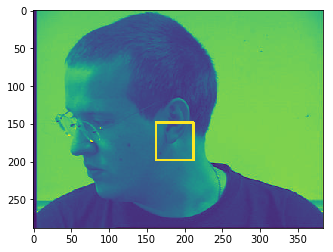

person01126-30+90.jpg
4.53424084765655
3.1783638936706606


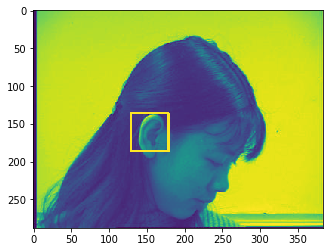

person03101-60-90.jpg
5.367394007925196
4.330795529274756
3.220555353925929


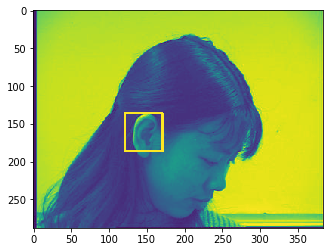

person03102-60-75.jpg
4.433168845219402
3.781664742685963
3.3574263113052574
3.1564182356741486


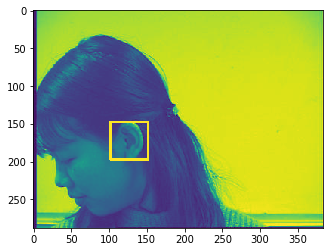

person03113-60+90.jpg
6.441551057571973
3.907320304757896


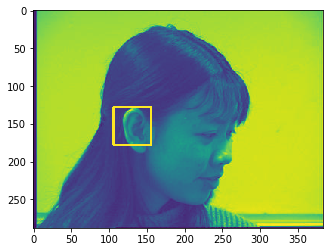

person03114-30-90.jpg
6.441551057571973
3.6443368662648155


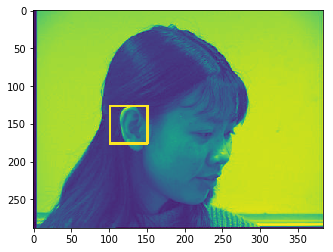

person03116-30-60.jpg
4.542476257619091
4.312734316100915
4.813195827879383
3.589616505972987
3.869094035088372


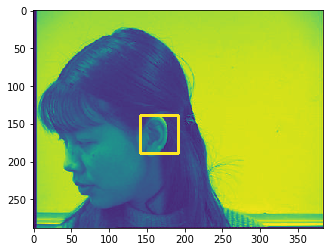

person03126-30+90.jpg
4.291837219792467
4.523582742669068
3.8983687321654115
3.201046704577955
2.432740439013417
3.0794350890910356
5.42852842943472
3.58142445677128


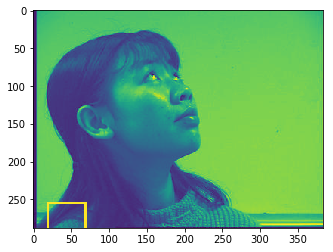

person03181+60-60.jpg
5.225621535362098
4.111345854478143
4.3174253702411045
3.4501450598750623
2.949087378792621
4.05278827079668


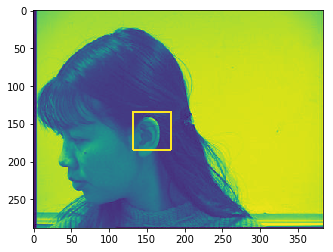

person03225-30+75.jpg
3.894723716197231
3.625574643584408


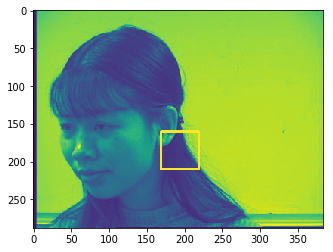

person03235-15+30.jpg
6.441551057571973
5.192948214876053
3.536466050421092
4.289478160299752


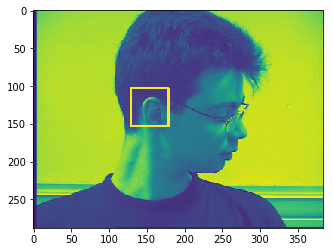

person05101-60-90.jpg
6.441551057571973
5.231501069891954
3.096807056584042


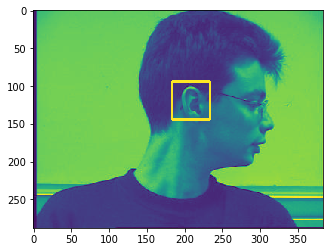

person05114-30-90.jpg
5.702434440361663
5.185258934689186
3.560717174276201


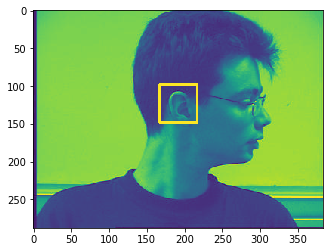

person05115-30-75.jpg
5.602793577990466
4.847577952764177
4.140250707239292


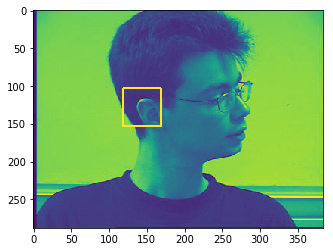

person05116-30-60.jpg
5.359926036902486
4.776123763948569
3.2234878173281505
4.505800583685371
3.551042783328442


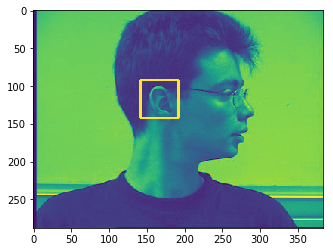

person05127-15-90.jpg
5.363143195201907
5.131543694996665
3.3904456544098083


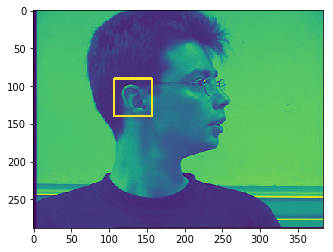

person05140+0-90.jpg
4.532130184843961
3.9259047994682055
4.565617625021121


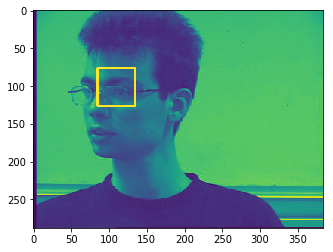

person05148+0+30.jpg
6.441551057571973
3.4900090846712204
2.4199983284661575
3.555700521752627
3.355892100987193


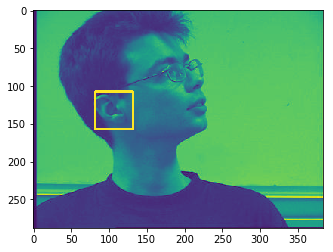

person05154+15-75.jpg
5.9253769651815364
1.8706291315690242
4.185970859344958
3.02892565867176
3.145812464378991


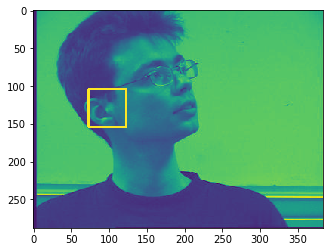

person05155+15-60.jpg
6.441551057571973
5.35822521639029
3.6438237165640817
5.00532173719357
4.159670092808743
4.530514745969699
3.608539902073287
4.132433443126797


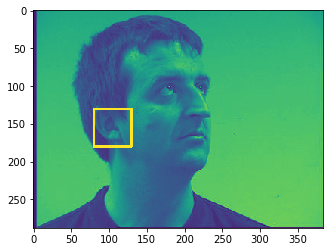

person07169+30-45.jpg
5.187849618891665
4.922257178020748
3.9054602963595717
3.131265752462373
3.9742810201895553
4.48525137470547


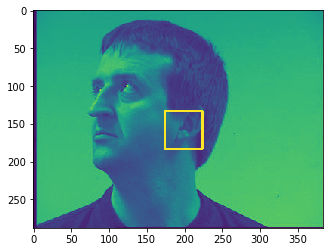

person07177+30+75.jpg
6.261627894560217
5.644630972672474
4.253172876642477
5.7016520710044905
4.443750861807533
4.506843727975317
4.079663934852954
4.194300435232529


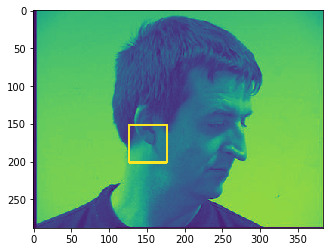

person07215-30-75.jpg
5.634920734750259
5.645016988275887
4.400887618183029
5.574986309546722
4.143272013519701
4.647300891852826
3.8701682476957786


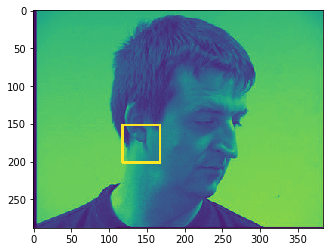

person07216-30-60.jpg
5.54330523122929
4.6262381586535035
3.9713575867116764
4.4196421441231735
3.7041965351272075
4.644465718124473
3.46785786766254


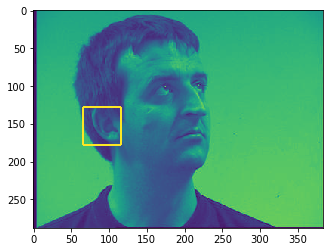

person07269+30-45.jpg
6.327179785817622
3.5584337020986965
3.6831027930903666
2.883799446102825
3.680229449449363
3.4702812612739424
3.264883482288627
3.5794632911864874


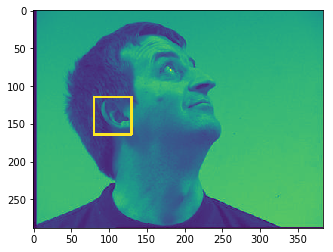

person07279+60-90.jpg


In [13]:
# find the ear in some of images. images for test are in testImages folder. first it takes the edge of image,
# then dilate it, removing small blobs, and label each component. then for each component, take the shape index, and compare it with model,
# and choose the most promising region as ear candidate. 
def OnlineEarDetector(model):
    for fname in os.listdir('testImages/'):
        
        image = imageReader("testImages/"+fname)

        edged = edging(image)
        dilated = dilation(edged)
        dilated = removingSmallBlobs(dilated)
        labeledBinaryImage, nr_objects = com_analisys(dilated)
        #getting the (x,y) means of each region
        mX, mY = regionMeaner(labeledBinaryImage, nr_objects)

        finalregXMean, finalregYMean= regionChecker(model, labeledBinaryImage,nr_objects, mX, mY)
        finalReg = cv2.rectangle(image, (int(finalregYMean)-25, int(finalregXMean)-25), (int(finalregYMean)+25, int(finalregXMean)+25),(255,0,0), 2)
        plt.imshow(finalReg)
        
        plt.show()
        print(str(fname))
        
model = modelBuilder()
OnlineEarDetector(model)